# Assignment: Deep Research Agent for Due Diligence
Tejasvi Sharma

#### Setup Libraries

In [ ]:
!pip3 install langchain 
!pip3 install langgraph
!pip3 install langchain_community 
!pip3 install langchain-cohere  
!pip3 install langchain-core 
!pip3 install tiktoken 
!pip3 install langchain-openai
!pip3 install langchain-google-genai
!pip3 install langchainhub 
!pip3 install tavily-python 
!pip3 install eventregistry
!pip3 install datetime
!pip3 install pandas
!pip3 install matplotlib
!pip3 install langgraph-checkpoint-sqlite
!pip3 install Pillow
!pip3 install pyyaml
!pip3 install -qU langchain-community wikipedia
!pip3 install openpyxl
!pip3 install mlflow

In [1]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

In [304]:
import logging
logger = logging.Logger('./logs')

In [ ]:
import mlflow
mlflow.langchain.autolog()
mlflow.set_experiment("Sample Due Diligence Agent")

### Load Secrets to call api for models and tools

In [305]:
import yaml

with open("secrets.yaml") as stream:
    try:
        secret_dict = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        logger.error("Error Loading Secrets!! secrets.yaml file not present")
        logger.error(exc)

### Load Models

In [ ]:
from langchain_openai import ChatOpenAI
try:
    openai_api_key = secret_dict['openai_api_key']
    model = ChatOpenAI(model="gpt-3.5-turbo",api_key = openai_api_key, temperature=0)
except Exception as e:
    logger.error("Error in accessing model")
    logger.error(str(e))

Tavily client helps in web search

In [ ]:
from tavily import TavilyClient
import os
try:
    tavily_api_key = secret_dict['tavily_api_key']
    tavily = TavilyClient(api_key=tavily_api_key)
except Exception as e:
    logger.error("Error loading tavily tool")
    logger.error(str(e))

In [3]:
# To store queries in the format of List[str]
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

C:\Users\tejsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py:3699: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


### AGENT DEFINITION BEGINS 
AgentState
- plan_of_Action : The steps to be followed given an input query. Result of the output from the start prompt
- content: Contains the outputs of the different steps involved in the process.
- media : Contains the outputs of the adverse media step involved in the process.
- pep : Contains the outputs of the politically exposed person (PEP) step invovled in the process
- input_str : Contains the input string related to the person or the entity and extra document or other information.
- image_path: Optional Field of The image of the individual found in local records to be used for cross verification
- transaction_statement_path : Optional field of the transactional statement of the individual present in the records.

In [379]:

import operator
from typing import Annotated

class AgentState(TypedDict):
    plan_of_action: str
    content: Annotated[List[str], operator.add]
    media: str
    pep: str
    input_str: str
    image_path: str=None
    transaction_statement_path: str=None
    report: str
    error: bool=False
    transaction_monitoring:str=None

The Start Prompt for the process tied to the initial node in the Langgraph. This is devised taking help from the general steps that a Due Diligence expert follows and helps in providing reasoning to the process.
The outcome expected is to classify the entity or person into 3 types - Low, Medium, High risk.
A sample of the expected output is provided for reference.



In [398]:
START_PROMPT = """I want you to act as a due dligence expert and working as a KYC and compliance expert for a fintech company. You want to identify if a particular person or an entity is a risk for your company, because the person is a Politically exposed pereson or a high net worth individual or a person with adverse media or involved in money laundering activities.\
  Being a compliance expert, you don't want the name of your company to be associated with such a person because it would bring defame and heavy sanctions from global bodies like FinCen, Ofac etc.\
    What will be the steps that you follow and checklist to be used to flag the person as a potential red flag. Think step by step and cross verify the facts with references.\
  Please cross verify the facts with the input given in the query, make use of demographic information or image provided or the transaction statement if available. 
  Output the overall risk rating as -
  
  LOW - If no red flags are observed in terms of adverse media or PEP linkage or High Net Worth Individual or Transactional red flags. As next steps, the person needs not be monitored and should not be treated with caution at all.
  MEDIUM - IF red flags are observed in terms of adverse media or PEP linkage or High Net Worth Individual , but there is no direct involvement but the person to be monitored is a close associate or a family member of a person with PEP or Adverse Media. As next steps, the person should be closely monitored with Enhanced Due Diligence for some time.
  HIGH - If red flags are observed in terms of adverse media or PEP linkage or High Net Worth Individual or no Transactional red flags are observed. As the next action, the person should not be allowed to continue business with the bank.
  
  If the KYC verification fails based on comparing the demographic information or image, deem the entity as medium risky
 
 
When I give you a person’s or entity’s name, you must:
1. Conduct open-source due diligence (use factual, verifiable data).
2. Assess if the subject poses a risk under global compliance standards (PEP, sanctions, adverse media, money laundering, fraud, etc.).
3. Output the result **strictly in the following JSON format** — no extra commentary, no markdown, no explanations outside the JSON.

---
JSON OUTPUT FORMAT:
{
  "short_answer": {
    "name": "<entity_or_person_name>",
    "overall_risk_rating": "<Low / Medium / High>",
    "is_red_flag": "<Yes / No — with short reasoning>",
    "summary": "<2–4 line summary of the entity/person, explaining main risk factors or clean profile indicators>"
  },
  "long_answer": {
    "basic_information": {
      "full_name": "<if available>",
      "aliases": "<if any>",
      "country_of_origin": "<if known>",
      "primary_business_or_occupation": "<if known>",
      "known_associates": "<if any>",
      "sources": ["<list of credible sources with links>"]
    },
    "risk_checklist": {
      "pep_status": { "status": "<Yes/No>", "details": "<explanation>" },
      "sanctions_watchlists": { "status": "<Yes/No>", "details": "<explanation>" },
      "adverse_media": { "status": "<High/Medium/Low>", "details": ["<headline or summary>", "<headline or summary>"] },
      "criminal_records": { "status": "<Yes/No>", "details": "<if any>" },
      "financial_profile": { "status": "<Strong/Weak/Unclear>", "details": "<summary>" },
      "ubo_and_corporate_linkages": { "status": "<Transparent/Hidden/Complex>", "details": "<summary>" },
      "transactional_red_flags": { "status": "<Yes/No/Unclear>", "details": "<summary>" }
    },
    "risk_assessment_summary": {
      "sanctions_risk": "<Low/Medium/High>",
      "regulatory_risk": "<Low/Medium/High>",
      "reputational_risk": "<Low/Medium/High>",
      "criminal_risk": "<Low/Medium/High>",
      "overall_risk_rating": "<Low/Medium/High>",
      "risk_reasoning": "<1–2 paragraph reasoning>"
    },
    "recommendation": {
      "onboarding_decision": "<Proceed / Proceed with EDD / Decline>",
      "edd_measures_if_needed": [
        "<EDD step 1>",
        "<EDD step 2>"
      ]
    }
  }
}
---

Always ensure:
- The JSON is **syntactically valid** (no comments, no markdown).
- Each risk field contains a short but factual assessment.
- You must not include any explanation or text outside the JSON object.
 """

def start_node(state: AgentState):
  try:
    messages = [
        SystemMessage(content=START_PROMPT), 
        HumanMessage(content=state['input_str'])
    ]
    response = model.invoke(messages)
    return {"plan_of_action": response.content}
  except Exception as e:
    logger.error(str(e))
    logger.error("Error from starting node")
    return {'plan_of_action': 'Some error occured -'+str(e),'error':True}

The report gen prompt which is responsible for generating the final report basis the outputs of the intermediate steps

In [ ]:
REPORT_GEN_PROMPT = """Summarize the findings as a concise report with a clear output whether this person is risky or not as per the report json format given earlier. Consider the PEP, ADVERSE MEDIA and TRANSACTION RED Flags information.
Think step by step!
------

{content}
"""
def report_gen_node(state: AgentState):
    try:
        content = "PEP:"+" \n\n".join( state['pep'][:-2] or [])
        content = content+" ADVERSE MEDIA:"+ "\n\n".join( state['media'][:-2] or [])
        content = content+" TRANSACTION RED FLAGS:"+"\n\n".join( state['transaction_monitoring'] or [])
        user_message = HumanMessage(
            content=f"{state['input_str']} and {state['plan_of_action']}")
        messages = [
            SystemMessage(
                content=REPORT_GEN_PROMPT.format(content=content)
            ),
            user_message
            ]
        response = model.invoke(messages)
        return {
            "report": response.content, 
        }
    except Exception as e:
        logger.error(str(e))
        logger.error("Error from report gen node")
        print("Error")
        return {'report': 'Some error occured -'+str(e),'error':True}

The search adverse prompt responsible for searching any negative puublicity pertaining to the individual or entity.\
    It currently relies on the internet based search using Tavily Search tool. In a production setting, we might want to replace it with an API of WorldCheck, LExus NExus or a customized solution from SumSub which provides API to search these.searching

In [448]:
SEARCH_ADVERSE_PROMPT = """You are a Finance Crime expert charged with providing information that can \
be used to identify if a given person has bee involved in media. Focus on all kind of information both positive and negative \
Generate a list of search queries that given a person'name can look web for the public perception of this person's image. Only generate 3 queries max.
Return the relevant hyperlinks as well for references to cross verify
"""

def search_media_node(state: AgentState):
    try:
        queries = model.with_structured_output(Queries).invoke([
            SystemMessage(content=SEARCH_ADVERSE_PROMPT),
            HumanMessage(content=state['input_str'])
        ])
        content = []
        for q in queries.queries:
            response = tavily.search(query=q, max_results=2)
            for r in response['results']:
                content.append(r['content'])
        return {"media":content}
    except Exception as e:
        logger.error(str(e))
        logger.error("Error from search media node")
        return {'media': 'Some error occured -'+str(e),'error':True}

The Pep(Politically Exposed Person) prompt responsible for searching any negative publicity pertaining to the individual or entity.\
    It currently relies on the internet based search using Tavily Search tool. In a production setting, we might want to replace it with an API of WorldCheck, LExus NExus or a customized solution from SumSub which provides API to search these.searching

In [449]:
CHECK_FOR_PEP_PROMPT = """You are a Finance Forensic Crime expert charged with providing information that can \
be used to identify if a given person has links to Politically Exposed Persons i.e those in power currently or in the recent past. This links may include a direct family connection or \
    being a close accomplice or an acquaintance.\
Generate a list of search queries that given a person'name can look web for the political linkage of this person either directly or indirectly. Only generate 3 queries max.
Return the relevant hyperlinks as well for references to cross verify
"""

def search_pep_node(state: AgentState):
    try:
        queries = model.with_structured_output(Queries).invoke([
            SystemMessage(content=CHECK_FOR_PEP_PROMPT),
            HumanMessage(content=state['input_str'])
        ])
        content = []
        for q in queries.queries:
            response = tavily.search(query=q, max_results=2)
            for r in response['results']:
                content.append(r['content'])
        return {"pep": content}
    except Exception as e:
        logger.error(str(e))
        logger.error("Error from search media node")
        return {'pep': 'Some error occured -'+str(e),'error':True}

In [450]:

import pandas as pd
TRANSACTION_LIMIT = 100000
def transaction_monitoring_node(state: AgentState):
    try:
        # print(state)
        df = pd.read_csv(state['transaction_statement_path'])
        filtered_df = df[df['transaction_amount']>TRANSACTION_LIMIT]
        if len(filtered_df):
            response = f'YES, as per the transaction monitoring activity there is transactional red flag, the individual has made a high value transaction of more than {TRANSACTION_LIMIT} $ in last 1 month'
        else:
            response = f'NO, as per the transaction monitoring activity, there is no transactional red flag, the individual has not made a high value transaction of more than {TRANSACTION_LIMIT} $ in last 1 month'

        return {"transaction_monitoring":[response]}
    except Exception as e:
        logger.info('Some error occured during transaction_monitoring_node')
        logger.info(str(e))
        return {"transaction_monitoring":['NO, There is no information related to Transaction monitoring activity so there is no transactional red flag']}

In [451]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0,api_key=openai_api_key)
builder = StateGraph(AgentState)
builder.add_node("start_node", start_node)
builder.add_node("report_gen_node", report_gen_node)
builder.add_node("search_media_node",search_media_node)
builder.add_node("search_pep_node",search_pep_node)
builder.add_node("transaction_monitoring_node", transaction_monitoring_node)
builder.add_edge("start_node", "search_media_node")
builder.add_edge("start_node", "transaction_monitoring_node")
builder.add_edge("start_node", "search_pep_node")
builder.add_edge("transaction_monitoring_node", "report_gen_node")
builder.add_edge('search_media_node','report_gen_node')
builder.add_edge('search_pep_node','report_gen_node')
builder.add_edge('report_gen_node',END)

builder.set_entry_point("start_node")

In [452]:
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod
graph = builder.compile()
graph.get_graph().draw_mermaid_png(
    output_file_path="Due_Dligence_Agent_flow.png",
    curve_style=CurveStyle.LINEAR,
    draw_method=MermaidDrawMethod.API, # or MermaidDrawMethod.LOCAL if you have local setup
    background_color="white"
)


b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\xad\x00\x00\x01\xb0\x08\x02\x00\x00\x00\x0c\x9e\xcb$\x00\x00\x10\x00IDATx\x9c\xec\xdd\x07`\x13\xd5\x1f\x07\xf0wI\xf7\x1e@\x0b\x1d\x94\xb6@\xd9C@D\x85\xbf"C\x94%{\xcb\x10\x05T\xa6\x08\x02\xb2\x15d\x88"C\xc4\xc1\x10A\x01\x01\xc5\x85,\x01\x05eC\x99]\x94B[\xe8\xde+\xb9\xff/\xb9r\x846I\x9b\xd24\x97\xe4\xfb\xa1\xc6\xcb\xad\\.\xef\xde\xfb\xdd{w\xeflx\x9eg\x00\x00\x00`\x95l\x18\x00\x00\x00X+\xc4\x01\x00\x00\x00\xd6\x0bq\x00\x00\x00\x80\xf5B\x1c\x00\x00\x00`\xbd\x10\x07\x00\x00\x00X/\xc4\x01\x00\x00\x00\xd6\x0bq\x00@%\xb8~&-\xf2bNfRa\x91\x82\x15\x16(8NVz\x1e\xb9\x8dLQ\xa4\xd42\xdeV\xa6(\xd42\xde\xc6VV$\x8c\xe7\x18\xd3\xb8\xbd\x97\xe3X\xe9\xbb}e2N\xa9\xe4\x1f]-\xa7(|t\x8c\x9cS(x\x8d\xed\xe1\xec\xece\xae^\xf2\x80\xfa\x8e\x8d\x9f\xf2d\x00`\x958\xf4\x1f\x00Pa\'\x7fI\xba\xfaofN&\x15\xfcTl\xab\x8a^;{ya\xa1\xd2F&/=\xb3\xcc\x86S\x16i9\xdc\xa8<Vh\x1d/\x16\xe4\x1c\xcfxN\x18I\xefe\xda\xe2\x00\n<x\xa5\x8e\xc5\x1fn\x00S\x16i,"\xe7)t\xa0\x8f.\xc8U*\x14\xcc\xd

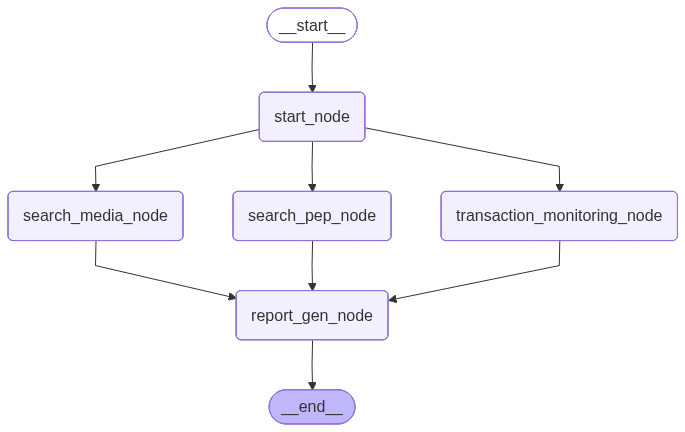

In [453]:
from IPython.display import Image
Image(filename='Due_Dligence_Agent_flow.png') 

### AGENT DEFINITION COMPLETE

### LOADING THE TEST SET
Here the baseline solution is the results by Chatgpt using the same prompt as the prompt in the START_NODE

In [454]:
test_df =pd.read_excel('./test_set.xlsx')
test_df

,name,overall_risk_rating,is_red_flag,summary,name_query
0,Axact (Axact Pvt. Ltd.),High,"Yes â€” major adverse-media, criminal convicti...",Axact has been the subject of high-profile inv...,NaN
1,Gurmeet Singh Jolly (aka Shera),Low â†’ Medium (reputational exposure),No (not a PEP or sanctions-listed). Moderate r...,"Gurmeet Singh Jolly, widely known as Shera, is...",NaN
2,"Joe Marsh (claimed location: Mumbai, Maharashtra)",Unknown / Ambiguous,"No clear evidence of sanctions, PEP status, or...",There are many public profiles and bylines for...,"Joe Marsh (claimed location: Mumbai, Maharashtra)"
3,Mukesh Dhirubhai Ambani,Medium,Partially â€” requires Enhanced Due Diligence ...,Mukesh Ambani is a high-profile Indian busines...,NaN
4,Oyo (Oravel Stays Pvt. Ltd. / Oyo Hotels & Homes),Medium â†’ High,"Yes â€” multiple legal, regulatory, and reputa...",Oyo has been repeatedly exposed in adverse med...,NaN
5,Sheikh Mohamed bin Zayed Al Nahyan (MBZ),High,Yes â€” given his status as a senior political...,Sheikh Mohamed bin Zayed is the President of t...,NaN


Query list containing a tuple of 3 values for each query \
(Name of the person/Entity, Description and inputs for the person/Entity, transaction file if any)

In [461]:
query_list = [
    ('Axact','Search for an entity named Axact',None),('Oyo','Search for an entity named Oyo',None),('Mukesh Ambani','Search for a person named Mukesh Ambani',None)\
    ,('Gurmeet Singh jolly','Search for a person named Gurmeet Singh Jolly',None),
    ('Joe Marsh','Search for a person named Joe Marsh who lives in Mumbai, Maharashtra','./low_net_worth_statement.csv'),\
        ('Sheikh Mohamed bin Zayed','Search for a person named Sheikh Mohamed bin Zayed',None)
    ]


In [462]:
from langgraph.checkpoint.sqlite import SqliteSaver
complete_output_list = []
response_output_list = []
from tqdm import tqdm
with SqliteSaver.from_conn_string(":memory:") as checkpointer:
    for query in tqdm(query_list):
        name,q,transaction_file = query
        graph = builder.compile(checkpointer=checkpointer)
        thread = {"configurable": {"thread_id": "1"}}
        out = graph.invoke({
        'input_str': q,
        'transaction_statement_path':transaction_file
        },thread)
        complete_output_list.append(out)
        response_output_list.append(out['report'])


  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\tejsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\langchain_openai\chat_models\base.py:1900: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
C:\Users\tejsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\langchain_openai\chat_models\base.py:1900: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
C:\Users\tejsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p

PEP:FATF Guidance politically exposed persons (recommendations 12 and 22) June 2013 FINANCIAL ACTION TASK FORCE The Financial Action Task Force (FATF) is an independent inter-governmental body that develops and promotes policies to protect the global financial system against money laundering, terrorist financing and the financing of proliferation of weapons of mass destruction. The FATF Recommendations are recognised as the global anti-money laundering (AML) and counter-terrorist financing (CFT) standard. A politically exposed person (PEP) is defined by the Financial Action Task Force (FATF) as an individual who is or has been entrusted with a prominent public function. To address these risks, FATF Recommendations 12 and 22 require countries to ensure that financial institutions and designated non-financial businesses and professions (DNFBPs) implement measures to prevent the misuse of the financial system and non-financial businesses and professions by PEPs, and to detect such potenti

 17%|█▋        | 1/6 [00:18<01:30, 18.10s/it]C:\Users\tejsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\langchain_openai\chat_models\base.py:1900: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
C:\Users\tejsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\langchain_openai\chat_models\base.py:1913: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  

PEP:International Journal of Law, Political Science, and Administration Vol.1, No.2, pp.11-30, March 2014 ) www.gbjournals.org Published by British Research Institute UK ( 11 HARD AND SOFT POWER POLITICS: THE DYNAMICS OF OYO-DAHOMEY DIPLOMATIC RELATIONS 1708-1791 Femi Adegbulu (Ph.D) ABSTRACT: This paper, following the assumptions of the Realist School, takes a critical look at ‘power’ and the use of it, with relations to pre-colonial Oyo and her neighbor, Dahomey in the eighteenth century. Cana itself appears to have been the Oyo headquarters, where the kings of International Journal of Law, Political Science, and Administration Vol.1, No.2, pp.11-30, March 2014 ) www.gbjournals.org Published by British Research Institute UK ( 21 Dahomey had a palace but no authority at all and where any Dahomean was free to live. 

The political authority of the Alafin was significantly diminished. Oba Atiba sought with some success to check the rising power of the Oyo Mesi in the new 

Members of th

 33%|███▎      | 2/6 [00:40<01:21, 20.39s/it]C:\Users\tejsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\langchain_openai\chat_models\base.py:1900: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
C:\Users\tejsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\langchain_openai\chat_models\base.py:1913: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  

PEP:Item 1 of 2 Mukesh Ambani, Chairman and Managing Director of Reliance Industries, arrives to address the company's annual general meeting in Mumbai, India July 5, 2018. **[1/2]**Mukesh Ambani, Chairman and Managing Director of Reliance Industries, arrives to address the company's annual general meeting in Mumbai, India July 5, 2018. MUMBAI (Reuters) - India's wealthiest man and its richest banker are backing a politician of Congress, the main opposition party, in general election, a rare public endorsement by two of the country's most influential businessmen. Mukesh Ambani, who heads Reliance Industries, and Uday Kotak, managing director of Kotak Mahindra Bank, both endorsed Milind Deora, the Congress candidate for the South Mumbai constituency. 

[Skip to main content](https://www.project-syndicate.org/commentary/trump-trade-tactics-hit-modi-where-it-hurts-by-jayati-ghosh-2025-08#main) *   [Newsletters](https://www.project-syndicate.org/newsletters) *   [Subscribe](https://www.pro

 50%|█████     | 3/6 [01:01<01:02, 20.96s/it]C:\Users\tejsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\langchain_openai\chat_models\base.py:1900: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
C:\Users\tejsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\langchain_openai\chat_models\base.py:1913: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  

PEP:He has recently started his political stint last year when he joined Shiv Sena. Born on 19th & ruled by no. 1 shares great compatibility with 

Shera, whose real name is Gurmeet Singh Jolly, has been Salman's bodyguard since 1995. ... Additionally, Shera joined the political party Shiv 

If notability cannot be shown, the article is likely to be merged, redirected, or deleted.*Find sources:* "Shera" Indian bodyguard – news **·** newspapers **·** books **·** scholar **·** JSTOR *(October 2019)* *(Learn how and when to remove this message)* | **Gurmeet Singh Jolly** (born 19 May 1969), also known as **Shera**, is an Indian celebrity bodyguard. [edit&action=edit&section=2 "Edit section: Salman Khan's bodyguard")] 2. **^** "Salman Khan's bodyguard Shera escorts Justin Bieber as he arrives in Mumbai". 3. **^** "Justin Bieber India Tour: Salman Khan's Bodyguard Shera to Monitor Security". "Salman Khan's Bodyguard Shera Joins Shiv Sena". 5. **^** "Salman Khan's bodyguard Shera's salary wi

 67%|██████▋   | 4/6 [01:22<00:41, 20.69s/it]C:\Users\tejsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\langchain_openai\chat_models\base.py:1900: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
C:\Users\tejsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\langchain_openai\chat_models\base.py:1913: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  

PEP:The group had links to the English Defence League. And now, he's involved in far-right group Patriotic Alternative – set up in 2019 by former 

Seems then the Hampshire based kipper candidate for Caerphilly is embracing full blown white supremacism, and certainly that's the view of 

Jump to content ## Contents * Article * Download QR code * Download as PDF * Wikidata item **Joseph Marsh** (January 12, 1726 – February 9, 1811) was a Vermont politician and military officer who fought in the American Revolution and served as lieutenant governor of Vermont. Marsh died in Quechee, Vermont, on February 9, 1811. 4. **^** History of Hartford, Vermont, July 4, 1761 -- April 4, 1889, by William Howard Tucker, 1889, pages 371 to 372 Foote * Billings * Farnsworth * Jackson * Wilson * Williams "Benjamin Williams (Vermont politician)") * C. Categories: Hidden categories: * Articles with short description * Short description is different from Wikidata 

A database of political history and cemete

 83%|████████▎ | 5/6 [01:42<00:20, 20.62s/it]C:\Users\tejsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\langchain_openai\chat_models\base.py:1900: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
C:\Users\tejsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\langchain_openai\chat_models\base.py:1913: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  

PEP:Global Player: Sheikh Mohamed has enjoyed excellent personal relationships with previous US presidents, managing to have his views heard on Iran, the Muslim 

**His Highness Sheikh Mohamed bin Zayed Al Nahyan is the President of the United Arab Emirates and Ruler of Abu Dhabi.** His Highness Sheikh Mohamed bin Zayed Al Nahyan has been Chairman of the Abu Dhabi Executive Council since 2004. Working alongside the late Sheikh Khalifa bin Zayed Al Nahyan and the rulers of the other emirates, His Highness has dedicated his life in service to advancing the UAE’s social, economic and cultural development with the goal of realizing a more secure, flourishing, and sustainable future for his country and people. His Highness Sheikh Mohamed Bin Zayed Al Nahyan spent his earliest years against a backdrop of remarkable change in Abu Dhabi. 

# Mohammed Bin Zayed Al Nahyan President of the United Arab Emirates 11 Mar 1961 Khalifa bin Zayed Al Nahyan President of the United Arab Emirates from 2004

100%|██████████| 6/6 [02:08<00:00, 21.46s/it]


In [483]:
import re
def parse_due_diligence_output(raw_response: str):
    """
    Handles both JSON and formatted text (Markdown) outputs.
    Attempts to auto-structure the text into JSON format for consistency.
    """
    try:
        # Try loading as JSON first
        data = json.loads(raw_response)
        print("✅ Input recognized as valid JSON.\n")
        return data

    except json.JSONDecodeError:
        print("⚠️ Input is not valid JSON — attempting to convert Markdown to structured JSON...\n")

        # Extract key fields using regex patterns
        def extract(pattern):
            match = re.search(pattern, raw_response, re.IGNORECASE)
            return match.group(1).strip() if match else None

        # Extract common fields
        name = extract(r"Entity Name:\**\s*([^\n]+)")
        if name is None:
            name = extract(r"Entity:s*([^\n]+)")
        if name is None:
          name = extract(r"Name:\**\s*([^\n]+)")
          
        overall_risk = extract(r"Overall Risk Rating:\**\s*([^\n]+)")
        red_flag = extract(r"Red Flag:\**\s*([^\n]+)")
        summary = extract(r"Summary:\**\s*([^\n]+)")
        recommendation = extract(r"Onboarding Decision:\**\s*([^\n]+)")

        # Build structured JSON
        parsed_json = {
            "short_answer": {
                "name": name or "Unknown",
                "overall_risk_rating": overall_risk or "Unspecified",
                "is_red_flag": red_flag or "Unknown",
                "summary": summary or "No summary provided"
            },
            "long_answer": {
                "recommendation": recommendation or "Not specified",
                "source_text": raw_response.strip()
            }
        }

        print("✅ Successfully converted Markdown text into structured JSON.\n")
        print(json.dumps(parsed_json, indent=2))
        return parsed_json


In [472]:
response_output_list

["**Report on Axact:**\n\n- **Entity Name:** Axact\n- **Overall Risk Rating:** HIGH\n- **Red Flag:** Yes\n- **Summary:** Axact is a high-risk entity due to its involvement in a major diploma mill scandal, leading to legal issues and adverse media coverage.\n\n**Basic Information:**\n- **Full Name:** Axact\n- **Aliases:** Bol Group\n- **Country of Origin:** Pakistan\n- **Primary Business or Occupation:** Software and IT services\n- **Known Associates:** Shoaib Ahmed Shaikh (CEO)\n- **Sources:** [Wikipedia - Axact](https://en.wikipedia.org/wiki/Axact), [BBC News - Axact](https://www.bbc.com/news/world-asia-32702590)\n\n**Risk Checklist:**\n- **PEP Status:** No known PEP affiliations\n- **Sanctions Watchlists:** Not found in sanctions lists\n- **Adverse Media:** High - Involved in diploma mill scandal, legal issues, and adverse media coverage\n- **Criminal Records:** No specific criminal records found\n- **Financial Profile:** Unclear - Limited financial information available\n- **UBO and

In [482]:
response_output_list[1]

'### Risk Report for Entity: Oyo\n\n- **Overall Risk Rating:** Low\n- **Red Flag Identified:** No\n- **Summary:** Oyo is a well-known hospitality company with no red flags identified in terms of PEP, sanctions, adverse media, or money laundering activities.\n\n#### Detailed Findings:\n- **Basic Information:**\n  - Full Name: Oyo\n  - Aliases: None\n  - Country of Origin: India\n  - Primary Business or Occupation: Hospitality\n  - Known Associates: Ritesh Agarwal (Founder)\n  - Sources: [Oyo Website](https://www.oyorooms.com/), [Wikipedia](https://en.wikipedia.org/wiki/Oyo_Rooms)\n\n- **Risk Checklist:**\n  - PEP Status: No known political exposure\n  - Sanctions Watchlists: Not found in any sanctions lists\n  - Adverse Media: Low risk, with positive news like global expansion and funding partnerships\n  - Criminal Records: No criminal records found\n  - Financial Profile: Strong with successful global expansion and funding rounds\n  - UBO and Corporate Linkages: Transparent, founder an

In [487]:
parsed_response_output_list = [parse_due_diligence_output(output) for output in response_output_list]
parsed_response_output_list = [p['long_answer'] for p in parsed_response_output_list if p is not None]
pd.DataFrame.from_dict(parsed_response_output_list).to_excel("./test_set_model_detailed_report.xlsx",index=False)

⚠️ Input is not valid JSON — attempting to convert Markdown to structured JSON...

✅ Successfully converted Markdown text into structured JSON.

{
  "short_answer": {
    "name": "Axact",
    "overall_risk_rating": "HIGH",
    "is_red_flag": "Yes",
    "summary": "Axact is a high-risk entity due to its involvement in a major diploma mill scandal, leading to legal issues and adverse media coverage."
  },
  "long_answer": {
    "recommendation": "Decline",
    "source_text": "**Report on Axact:**\n\n- **Entity Name:** Axact\n- **Overall Risk Rating:** HIGH\n- **Red Flag:** Yes\n- **Summary:** Axact is a high-risk entity due to its involvement in a major diploma mill scandal, leading to legal issues and adverse media coverage.\n\n**Basic Information:**\n- **Full Name:** Axact\n- **Aliases:** Bol Group\n- **Country of Origin:** Pakistan\n- **Primary Business or Occupation:** Software and IT services\n- **Known Associates:** Shoaib Ahmed Shaikh (CEO)\n- **Sources:** [Wikipedia - Axact](http

In [488]:
# response_output_list[0
parsed_response_output_list = [parse_due_diligence_output(output) for output in response_output_list]
parsed_response_output_list = [p['short_answer'] for p in parsed_response_output_list if p is not None]
pd.DataFrame.from_dict(parsed_response_output_list).to_excel("./test_set_model_output.xlsx",index=False)

⚠️ Input is not valid JSON — attempting to convert Markdown to structured JSON...

✅ Successfully converted Markdown text into structured JSON.

{
  "short_answer": {
    "name": "Axact",
    "overall_risk_rating": "HIGH",
    "is_red_flag": "Yes",
    "summary": "Axact is a high-risk entity due to its involvement in a major diploma mill scandal, leading to legal issues and adverse media coverage."
  },
  "long_answer": {
    "recommendation": "Decline",
    "source_text": "**Report on Axact:**\n\n- **Entity Name:** Axact\n- **Overall Risk Rating:** HIGH\n- **Red Flag:** Yes\n- **Summary:** Axact is a high-risk entity due to its involvement in a major diploma mill scandal, leading to legal issues and adverse media coverage.\n\n**Basic Information:**\n- **Full Name:** Axact\n- **Aliases:** Bol Group\n- **Country of Origin:** Pakistan\n- **Primary Business or Occupation:** Software and IT services\n- **Known Associates:** Shoaib Ahmed Shaikh (CEO)\n- **Sources:** [Wikipedia - Axact](http